<a href="https://colab.research.google.com/github/Evans-Karani/iris-decision-tree/blob/main/nlp_spacy_amazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install spaCy and Vader
!pip install spacy vaderSentiment

# Download the small English model for spaCy
!python -m spacy download en_core_web_sm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import spacy
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize the Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

print("spaCy and Vader are ready!")


spaCy and Vader are ready!


In [4]:
from google.colab import files
uploaded = files.upload()  # now select test.ft.txt.bz2


Saving test.ft.txt.bz2.zip to test.ft.txt.bz2.zip


In [6]:
!unzip test.ft.txt.bz2.zip


Archive:  test.ft.txt.bz2.zip
  inflating: test.ft.txt.bz2         


In [7]:
!bunzip2 test.ft.txt.bz2


In [8]:
!ls


sample_data  test.ft.txt  test.ft.txt.bz2.zip


In [9]:
import pandas as pd

# Read the FastText‐style file, splitting off the label
data = []
with open("test.ft.txt", "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        if len(parts) < 2:
            continue
        label = parts[0].replace("__label__", "")     # e.g. “1” or “2”
        text  = parts[1]                               # the actual review
        data.append((label, text))

# Create DataFrame
df_reviews = pd.DataFrame(data, columns=["label", "review_text"])

# Peek at the first few rows
print(df_reviews.shape)
df_reviews.head()


(400000, 2)


,label,review_text
0,2,Great CD: My lovely Pat has one of the GREAT v...
1,2,One of the best game music soundtracks - for a...
2,1,Batteries died within a year ...: I bought thi...
3,2,"works fine, but Maha Energy is better: Check o..."
4,2,Great for the non-audiophile: Reviewed quite a...


In [12]:
def analyze_review(text):
    # Parse with spaCy
    doc = nlp(text)
    # Extract org/product entities
    entities = [ent.text for ent in doc.ents if ent.label_ in ("ORG", "PRODUCT")]
    # Vader compound score
    vs = analyzer.polarity_scores(text)["compound"]
    # Map to labels
    if vs >  0.05:
        sentiment = "Positive"
    elif vs < -0.05:
        sentiment = "Negative"
    else:
        sentiment = "Neutral"
    return {
        "Entities":       entities,
        "Sentiment":      sentiment,
        "CompoundScore":  vs
    }


In [13]:
sample_reviews = df_reviews.head(1000).copy()
results        = sample_reviews["review_text"].apply(analyze_review).apply(pd.Series)
df_out         = pd.concat([sample_reviews, results], axis=1)
df_out.head(10)


,label,review_text,Entities,Sentiment,CompoundScore
0,2,Great CD: My lovely Pat has one of the GREAT v...,"[GREAT, EVERYBODY]",Positive,0.9642
1,2,One of the best game music soundtracks - for a...,[],Positive,0.9082
2,1,Batteries died within a year ...: I bought thi...,[],Positive,0.7297
3,2,"works fine, but Maha Energy is better: Check o...",[Their Powerex MH-C204F],Positive,0.8945
4,2,Great for the non-audiophile: Reviewed quite a...,[VHS],Positive,0.8388
5,1,DVD Player crapped out after one year: I also ...,"[hte, JVC, Sony]",Negative,-0.3506
6,1,"Incorrect Disc: I love the style of this, but ...",[JVC],Negative,-0.0638
7,1,DVD menu select problems: I cannot scroll thro...,[],Negative,-0.6737
8,2,Unique Weird Orientalia from the 1930's: Exoti...,[],Positive,0.1280
9,1,"Not an ""ultimate guide"": Firstly,I enjoyed the...",[],Positive,0.9647


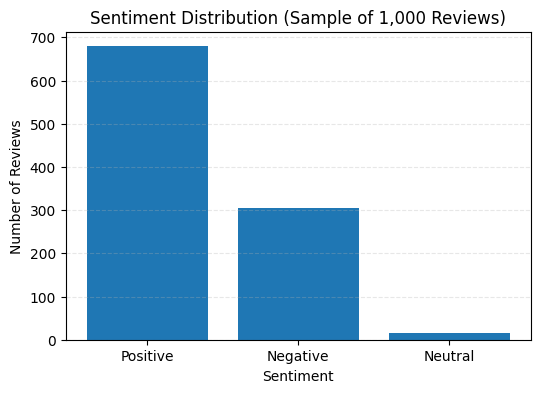

In [14]:
# Count how many reviews fall into each sentiment category
sentiment_counts = df_out["Sentiment"].value_counts()

# Plot with pure matplotlib
plt.figure(figsize=(6,4))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.title("Sentiment Distribution (Sample of 1,000 Reviews)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.show()


In [15]:
df_out.to_csv("amazon_review_analysis.csv", index=False)
